# Profiling of `maze_dataset` serializing/loading/saving/reading

In [1]:
import os
import itertools
from typing import Callable, Any
import cProfile
import pstats
import copy
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from muutils.statcounter import StatCounter

from maze_dataset import (
    MazeDataset,
    MazeDatasetConfig,
	set_serialize_minimal_threshold,
)
from maze_dataset.generation.generators import GENERATORS_MAP
from maze_dataset.utils import timeit_fancy, FancyTimeitResult

## Generate Datasets


In [2]:
cfgs: list[MazeDatasetConfig] = [
    MazeDatasetConfig(
		name="test",
		grid_n=grid_n,
		n_mazes=n_mazes,
		maze_ctor=GENERATORS_MAP['gen_dfs'],
	)
    for grid_n, n_mazes in itertools.product(
		[10],
		np.logspace(1, 2, 2, dtype=int).tolist(), # 100, for CI tests
		# np.logspace(1, 3, 5, dtype=int).tolist(), # 1k
		# np.logspace(0, 4, 9, dtype=int).tolist(), # 10k, notebook results from this set
	)
]

datasets: list[MazeDataset] = [MazeDataset.from_config(cfg) for cfg in cfgs]

## Profile

In [3]:
columns: list[str] = ['grid_n', 'n_mazes', 'serialize', 'serialize_minimal', 'load', 'load_minimal', 'save', 'save_minimal', 'read', 'read_minimal']
speeds_data: list[dict] = list()


In [4]:
def wrapped_timeit_fancy(
        name: str,
        function: Callable,
        do_profiling: bool,
        repeats: int,
        timing_stat: Callable[[StatCounter], float],
    ) -> tuple[dict, Any]:
    output: dict = dict()

    result: FancyTimeitResult = timeit_fancy(
        function,
        get_return=True,
        do_profiling=do_profiling,
        repeats=repeats,
    )

    output[name] = timing_stat(result.timings)
    output[f"{name}:stats"] = result.timings
    if do_profiling:
        output[f"{name}:profiling"] = result.profile

    return output, result.return_value



def measure_dataset_speed(
        d: MazeDataset, 
        do_profiling: bool = True,
        repeats: int = 1,
        timing_stat: Callable[[StatCounter], float] = StatCounter.min,
    ) -> dict:
    if repeats > 1:
        warnings.warn("Repeats > 1, results might not be accurate due to generation metadata being collected.")
    kwargs_fancy_timeit: dict = dict(
        do_profiling=do_profiling,
        timing_stat=timing_stat,
        repeats=repeats,
    )
    set_serialize_minimal_threshold(None)
    _d_cpy: MazeDataset = copy.deepcopy(d)
    # set up row data
    row_data: dict = dict(
        grid_n=d.cfg.grid_n,
        n_mazes=d.cfg.n_mazes,
    )
    # serialization & loading
    info_serialize, result_serialize = wrapped_timeit_fancy(
        'serialize_full', _d_cpy._serialize_full, **kwargs_fancy_timeit
    )
    row_data.update(info_serialize)
    _d_cpy = copy.deepcopy(d)

    info_serialize_min, result_serialize_min = wrapped_timeit_fancy(
        'serialize_minimal', _d_cpy._serialize_minimal, **kwargs_fancy_timeit
    )
    row_data.update(info_serialize_min)
    _d_cpy = copy.deepcopy(d)

    # info_serialize_min_alt, result_serialize_min_alt = wrapped_timeit_fancy(
    #     'serialize_minimal_alt', _d_cpy._serialize_minimal_alt, **kwargs_fancy_timeit
    # )
    # row_data.update(info_serialize_min_alt)
    _d_cpy = copy.deepcopy(d)
    info_serialize_cat, result_serialize_cat = wrapped_timeit_fancy(
        'serialize_minimal_soln_cat', _d_cpy._serialize_minimal_soln_cat, **kwargs_fancy_timeit
    )
    row_data.update(info_serialize_cat)
    _d_cpy = copy.deepcopy(d)

    row_data.update(wrapped_timeit_fancy(
        'load_full', lambda: MazeDataset._load_full(result_serialize), **kwargs_fancy_timeit
    )[0])
    row_data.update(wrapped_timeit_fancy(
        'load_minimal', lambda: MazeDataset._load_minimal(result_serialize_min), **kwargs_fancy_timeit
    )[0])
    row_data.update(wrapped_timeit_fancy(
        'load_minimal_soln_cat', lambda: MazeDataset._load_minimal_soln_cat(result_serialize_cat), **kwargs_fancy_timeit
    )[0])
    
    # saving and loading
    path_default: str = f'../data/{d.cfg.to_fname()}.zanj'
    path_min: str = f'../data/{d.cfg.to_fname()}_min.zanj'

    # default
    set_serialize_minimal_threshold(None)
    _d_cpy = copy.deepcopy(d)
    row_data.update(wrapped_timeit_fancy(
        'save', lambda: _d_cpy.save(file_path=path_default), **kwargs_fancy_timeit
    )[0])
    _d_cpy = copy.deepcopy(d)

    row_data.update(wrapped_timeit_fancy(
        'read', lambda: MazeDataset.read(file_path=path_default), **kwargs_fancy_timeit
    )[0])

    # minimal
    set_serialize_minimal_threshold(0)
    _d_cpy = copy.deepcopy(d)
    row_data.update(wrapped_timeit_fancy(
        'save_minimal', lambda: _d_cpy.save(file_path=path_min), **kwargs_fancy_timeit
    )[0])
    _d_cpy = copy.deepcopy(d)
    
    row_data.update(wrapped_timeit_fancy(
        'read_minimal', lambda: MazeDataset.read(file_path=path_min), **kwargs_fancy_timeit
    )[0])

    # asserts
    # assert d == read_default
    # assert d == read_minimal

    # reset cfg?
    set_serialize_minimal_threshold(None)

    return row_data

## Profile small datasets only

In [5]:
for i, d in enumerate(datasets):
    print(f'Profiling {i+1}/{len(datasets)}:\t{d.cfg}')
    result = measure_dataset_speed(d)
    speeds_data.append(result)
    cols_short: str = str({k : v for k,v in result.items() if ':' not in k})
    print(f"\t{cols_short}")
    print(f"\t{str(d.cfg)}")

Profiling 1/9:	MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[], grid_n=10, n_mazes=1, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x000002044BC8AD40>, maze_ctor_kwargs={})
	{'grid_n': 10, 'n_mazes': 1, 'serialize_full': 0.001988600008189678, 'serialize_minimal': 0.0021772999316453934, 'serialize_minimal_soln_cat': 0.002378899953328073, 'load_full': 0.002351999981328845, 'load_minimal': 0.0012380999978631735, 'load_minimal_soln_cat': 0.004195999936200678, 'save': 0.02134229999501258, 'read': 0.010948900016956031, 'save_minimal': 0.021853100042790174, 'read_minimal': 0.0077757000690326095}
	MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[{'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}], grid_n=10, n_mazes=1, maze_ctor=<function LatticeMazeGenerators.gen_dfs a

### Results

In [6]:
SPEEDS: pd.DataFrame = pd.DataFrame(speeds_data)

SPEEDS


,grid_n,n_mazes,serialize_full,serialize_full:stats,serialize_full:profiling,serialize_minimal,serialize_minimal:stats,serialize_minimal:profiling,serialize_minimal_soln_cat,serialize_minimal_soln_cat:stats,...,save:profiling,read,read:stats,read:profiling,save_minimal,save_minimal:stats,save_minimal:profiling,read_minimal,read_minimal:stats,read_minimal:profiling
0,10,1,0.001989,{0.001988600008189678: 1},<pstats.Stats object at 0x000002045788DB90>,0.002177,{0.0021772999316453934: 1},<pstats.Stats object at 0x0000020457880CD0>,0.002379,{0.002378899953328073: 1},...,<pstats.Stats object at 0x0000020457895BD0>,0.010949,{0.010948900016956031: 1},<pstats.Stats object at 0x000002044B915250>,0.021853,{0.021853100042790174: 1},<pstats.Stats object at 0x0000020457858F10>,0.007776,{0.0077757000690326095: 1},<pstats.Stats object at 0x00000204577F5A10>
1,10,3,0.004024,{0.0040244999108836055: 1},<pstats.Stats object at 0x0000020457881DD0>,0.002216,{0.002215999993495643: 1},<pstats.Stats object at 0x0000020457823BD0>,0.002784,{0.0027842000126838684: 1},...,<pstats.Stats object at 0x000002045783C550>,0.015222,{0.01522189995739609: 1},<pstats.Stats object at 0x00000204577F2A50>,0.018385,{0.0183852999471128: 1},<pstats.Stats object at 0x0000020457874B50>,0.007356,{0.007356400019489229: 1},<pstats.Stats object at 0x0000020456797410>
2,10,10,0.002029,{0.002029099967330694: 1},<pstats.Stats object at 0x00000204578A7AD0>,0.003337,{0.0033373000333085656: 1},<pstats.Stats object at 0x00000204578A8250>,0.003874,{0.0038735000416636467: 1},...,<pstats.Stats object at 0x00000204567C0C90>,0.032646,{0.03264600003603846: 1},<pstats.Stats object at 0x0000020457883010>,0.019866,{0.019865899928845465: 1},<pstats.Stats object at 0x0000020457866750>,0.010976,{0.01097559998743236: 1},<pstats.Stats object at 0x0000020456770CD0>
3,10,31,0.002083,{0.0020833000307902694: 1},<pstats.Stats object at 0x00000204566D5E90>,0.006797,{0.0067968000657856464: 1},<pstats.Stats object at 0x00000204578A5710>,0.007814,{0.007813800009898841: 1},...,<pstats.Stats object at 0x00000204566CD690>,0.079497,{0.07949670008383691: 1},<pstats.Stats object at 0x00000204577A2E50>,0.018971,{0.01897090009879321: 1},<pstats.Stats object at 0x000002044CD5CB50>,0.007627,{0.0076274999883025885: 1},<pstats.Stats object at 0x000002044B914690>
4,10,100,0.003318,{0.0033178000012412667: 1},<pstats.Stats object at 0x00000204566DEB50>,0.001964,{0.0019642000552266836: 1},<pstats.Stats object at 0x00000204567892D0>,0.002348,{0.002348399953916669: 1},...,<pstats.Stats object at 0x0000020457838F50>,0.027730,{0.02772969997022301: 1},<pstats.Stats object at 0x000002044CD97C50>,0.021856,{0.021856300067156553: 1},<pstats.Stats object at 0x000002044CD2CE50>,0.008772,{0.008771799970418215: 1},<pstats.Stats object at 0x000002045780D410>
5,10,316,0.003361,{0.0033614999847486615: 1},<pstats.Stats object at 0x00000204565A3F90>,0.002898,{0.002898499951697886: 1},<pstats.Stats object at 0x0000020456662950>,0.004403,{0.004402699996717274: 1},...,<pstats.Stats object at 0x000002045672E490>,0.066877,{0.06687710003461689: 1},<pstats.Stats object at 0x00000204564B0DD0>,0.037657,{0.037657000008039176: 1},<pstats.Stats object at 0x00000204564F4390>,0.015283,{0.015283499960787594: 1},<pstats.Stats object at 0x0000020456568D10>
6,10,1000,0.007449,{0.007448500022292137: 1},<pstats.Stats object at 0x00000204564E5950>,0.004399,{0.004398599965497851: 1},<pstats.Stats object at 0x000002044A839710>,0.005521,{0.005521100014448166: 1},...,<pstats.Stats object at 0x00000204566E9CD0>,0.197700,{0.19769990001805127: 1},<pstats.Stats object at 0x0000020455F17410>,0.060992,{0.06099189992528409: 1},<pstats.Stats object at 0x000002045632D9D0>,0.024609,{0.024608899955637753: 1},<pstats.Stats object at 0x0000020456715F50>
7,10,3162,0.018301,{0.018301300005987287: 1},<pstats.Stats object at 0x000002045623D950>,0.007376,{0.007376400055363774: 1},<pstats.Stats object at 0x000002045788FF10>,0.012505,{0.012505099992267787: 1},...,<pstats.Stats object 

In [7]:


def compute_speedups(speeds: pd.DataFrame) -> pd.DataFrame:
    # for prefix in column_measurement_prefixes:
    #     speeds[f'{prefix}_speedup'] = speeds[f'{prefix}_full'] / speeds[f'{prefix}_minimal']
    speeds['serialize/speedup'] = speeds['serialize_full'] / speeds['serialize_minimal']
    speeds['load/speedup'] = speeds['load_full'] / speeds['load_minimal']
    speeds['save/speedup'] = speeds['save'] / speeds['save_minimal']
    speeds['read/speedup'] = speeds['read'] / speeds['read_minimal']

    return speeds

SPEEDS = compute_speedups(SPEEDS)

In [8]:
SPEEDS[[c for c in SPEEDS.columns if ':' not in c]]

,grid_n,n_mazes,serialize_full,serialize_minimal,serialize_minimal_soln_cat,load_full,load_minimal,load_minimal_soln_cat,save,read,save_minimal,read_minimal,serialize/speedup,load/speedup,save/speedup,read/speedup
0,10,1,0.001989,0.002177,0.002379,0.002352,0.001238,0.004196,0.021342,0.010949,0.021853,0.007776,0.913333,1.899685,0.976626,1.408092
1,10,3,0.004024,0.002216,0.002784,0.001372,0.001049,0.002920,0.025131,0.015222,0.018385,0.007356,1.816110,1.307722,1.366880,2.069205
2,10,10,0.002029,0.003337,0.003874,0.022445,0.001660,0.004587,0.045904,0.032646,0.019866,0.010976,0.608006,13.521265,2.310713,2.974416
3,10,31,0.002083,0.006797,0.007814,0.072862,0.001412,0.003299,0.098329,0.079497,0.018971,0.007627,0.306512,51.598115,5.183159,10.422380
4,10,100,0.003318,0.001964,0.002348,0.011458,0.002358,0.004305,0.102981,0.027730,0.021856,0.008772,1.689135,4.858870,4.711740,3.161233
5,10,316,0.003361,0.002898,0.004403,0.035081,0.004440,0.006956,0.060745,0.066877,0.037657,0.015283,1.159738,7.900547,1.613100,4.375771
6,10,1000,0.007449,0.004399,0.005521,0.107734,0.013340,0.018142,0.152956,0.197700,0.060992,0.024609,1.693380,8.076095,2.507800,8.033675
7,10,3162,0.018301,0.007376,0.012505,0.315544,0.039193,0.049472,0.443317,0.504563,0.157827,0.052560,2.481061,8.051086,2.808878,9.599672
8,10,10000,0.049999,0.020714,0.048132,0.999023,0.116590,0.126128,1.360802,1.581426,0.414688,0.141493,2.413732,8.568696,3.281510,11.176731


Plotting serialize timings and speedups
Plotting grid_n=10
Plotting load timings and speedups
Plotting grid_n=10
Plotting save timings and speedups
Plotting grid_n=10
Plotting read timings and speedups
Plotting grid_n=10


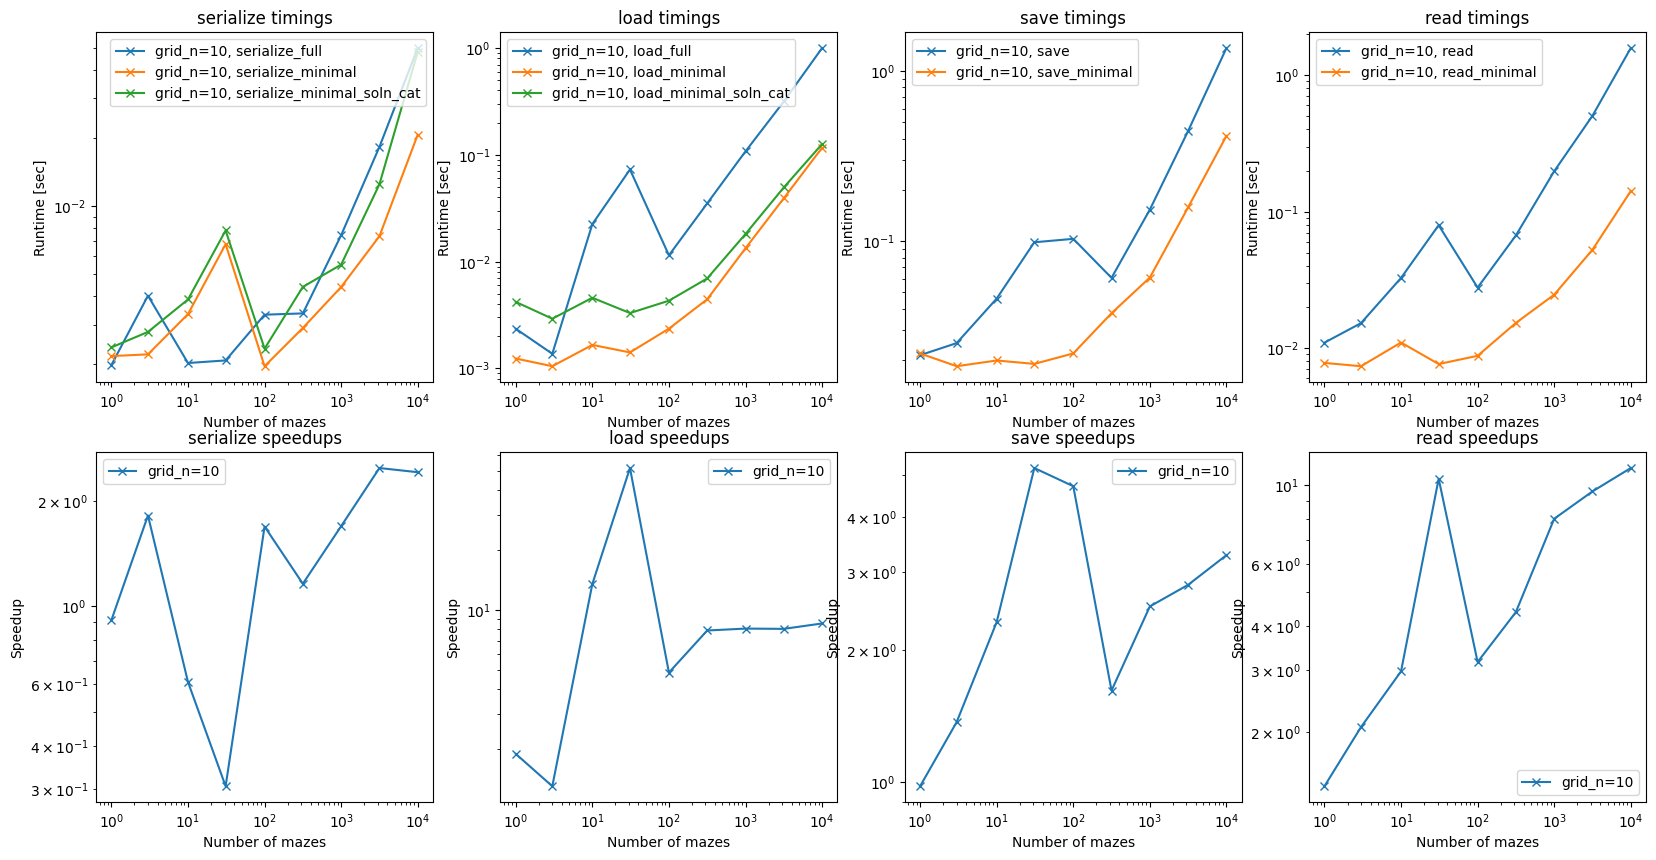

In [9]:
def plot_speeds(speeds: pd.DataFrame, column_measurement_prefixes: list[str] = ['serialize', 'load', 'save', 'read']) -> None:
    n_measurements: int = len(column_measurement_prefixes)
    fig, axs = plt.subplots(2, n_measurements, figsize=(n_measurements*5, 10))

    unique_grid_ns: list[int] = speeds['grid_n'].unique().tolist()

    for i, prefix in enumerate(column_measurement_prefixes):
        print(f'Plotting {prefix} timings and speedups')
        for grid_n in unique_grid_ns:
            print(f'Plotting grid_n={grid_n}')
            # raw timings
            ax_timings = axs[0, i]
            speeds_masked = speeds[speeds['grid_n'] == grid_n].sort_values('n_mazes')
            x_n_mazes = speeds_masked['n_mazes']

            # Plotting
            for col in speeds_masked.columns:
                if (prefix in col) and ('speedup' not in col) and (":" not in col):
                    ax_timings.plot(x_n_mazes, speeds_masked[col], "x-", label=f'grid_n={grid_n}, {col}')

            # Setting multiple properties with `set`
            ax_timings.set(xscale='log', yscale='log', xlabel='Number of mazes', ylabel='Runtime [sec]', title=f'{prefix} timings')
            ax_timings.legend()

            # speedups
            ax_speedups = axs[1, i]
            ax_speedups.plot(x_n_mazes, speeds_masked[f'{prefix}/speedup'], "x-", label=f'grid_n={grid_n}')

            # Setting multiple properties with `set` for ax_speedups
            ax_speedups.set(xscale='log', yscale='log', xlabel='Number of mazes', ylabel='Speedup', title=f'{prefix} speedups')
            ax_speedups.legend()


plot_speeds(SPEEDS)


Comparing rows 2 and 4, it appears that the `grid_n` has a relatively small effect on `serialize` and `load` runtimes. Those functions appear to run in $O(n_{\mathrm{mazes}})$ time. `grid_n` does impact `save` and `read`, but not their `_minimal` counterparts as much.

To compare the speed of analogous procedures vs `n_mazes`, the plots below show data from `speeds.loc[3:,:]`.

In [10]:
SPEEDS[['grid_n', 'n_mazes', 'serialize_minimal_soln_cat:profiling']]

,grid_n,n_mazes,serialize_minimal_soln_cat:profiling
0,10,1,<pstats.Stats object at 0x0000020457872C90>
1,10,3,<pstats.Stats object at 0x00000204577D7410>
2,10,10,<pstats.Stats object at 0x0000020456764590>
3,10,31,<pstats.Stats object at 0x00000204566509D0>
4,10,100,<pstats.Stats object at 0x000002044CE3A310>
5,10,316,<pstats.Stats object at 0x00000204566C67D0>
6,10,1000,<pstats.Stats object at 0x00000204564D6A90>
7,10,3162,<pstats.Stats object at 0x00000204565D2310>
8,10,10000,<pstats.Stats object at 0x000002044A88F010>


In [11]:
SPEEDS['serialize_minimal_soln_cat:profiling'][len(SPEEDS)-1].sort_stats('tottime').print_stats()

         16044 function calls (15819 primitive calls) in 0.044 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.026    0.026    0.044    0.044 maze_dataset.py:407(_serialize_minimal_soln_cat)
    10001    0.010    0.000    0.010    0.000 {built-in method numpy.array}
      724    0.002    0.000    0.004    0.000 tokenize.py:433(_tokenize)
        1    0.002    0.002    0.002    0.002 maze_dataset.py:414(<listcomp>)
      671    0.001    0.000    0.001    0.000 {method 'match' of 're.Pattern' objects}
        1    0.001    0.001    0.005    0.005 inspect.py:1224(getblock)
      723    0.000    0.000    0.000    0.000 inspect.py:1181(tokeneater)
      723    0.000    0.000    0.001    0.000 <string>:1(<lambda>)
    195/2    0.000    0.000    0.006    0.003 json_serialize.py:231(json_serialize)
      723    0.000    0.000    0.000    0.000 {built-in method __new__ of type object at 0x00007FFB8BC98F90}
      8/1  